<a href="https://colab.research.google.com/github/pastatimes/Master-Thesis-HateSpeech-Twitter/blob/master/Multi_Class_Text_Classification_with_baseline_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [210]:
#source: https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

import pandas as pd

data = pd.read_excel('/content/drive/My Drive/Annotated tweets/Annotated tweets/2019.xlsx')
data.head()

,gg_id,text,intent_id,intent.name,created_at,id_str
0,W6bc4eb9e,MEXICO IS PAYING FOR THE WALL through the many...,Neutral,Neutral,2019-01-01 00:40:00,1.080000e+18
1,L155b7fdb,Mexico is paying for the Wall through the new ...,Neutral,Neutral,2019-02-01 13:35:00,1.080000e+18
2,Ua4a19b29,The United States Treasury has taken in MANY b...,OffensiveLanguage,Offensive Language,2019-03-01 14:52:00,1.080000e+18
3,D710d1124,Michael Pillsbury interviewed by @cvpayne: â€œ...,Neutral,Neutral,2019-04-01 01:19:00,1.080000e+24
4,Rbf56205f,The Democrats could solve the Shutdown problem...,OffensiveLanguage,Offensive Language,2019-05-01 12:57:00,1.080000e+18


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Data cleaning and label preperation

In [211]:
col = ['text', 'intent_id']
df = data[col]
df = df[pd.notnull(df['text'])]

df['category_id'] = df['intent_id'].factorize()[0]
category_id_df = df[['intent_id', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'intent_id']].values)
df.head()

,text,intent_id,category_id
0,MEXICO IS PAYING FOR THE WALL through the many...,Neutral,0
1,Mexico is paying for the Wall through the new ...,Neutral,0
2,The United States Treasury has taken in MANY b...,OffensiveLanguage,1
3,Michael Pillsbury interviewed by @cvpayne: â€œ...,Neutral,0
4,The Democrats could solve the Shutdown problem...,OffensiveLanguage,1


Imbalanced Classes 

*** writing something here about how balanced the classes are

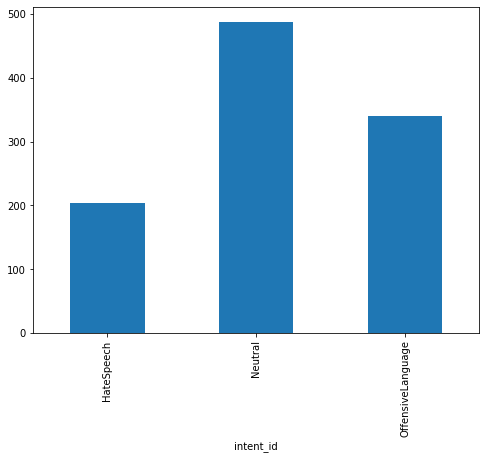

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('intent_id').text.count().plot.bar(ylim=0)
plt.savefig('/content/drive/My Drive/Annotated tweets/all_years.png')
plt.show()


Feature extraction

In [212]:
#Davidson (2017)
import nltk
nltk.download('stopwords')
import string
import re

from nltk.stem.porter import *
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

print(stopwords.words('english'))

stopwords = nltk.corpus.stopwords.words("english")
other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

stemmer = PorterStemmer()

def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) lots of whitespace with one instance
    2) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
        mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text

def tokenize(tweet):
    """Removes punctuation & excess whitespace, sets to lowercase,
    and stems tweets. Returns a list of stemmed tokens."""
    tweet = " ".join(re.split("[^a-zA-Z]*", tweet.lower())).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens


tfidf = TfidfVectorizer(
    #tfidf = CountVectorizer(),
    sublinear_tf=True, #for a logarithmic frequency of 1
    #tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words='english', #Removes stopwords
    use_idf=True,
    smooth_idf=False,
    norm='l2', #Applies l2 norm smoothing
    decode_error='replace',
    max_features=20000,
    min_df=2,#minimum numbers of documents a word must be present in to be kept
    max_df=0.501
    )

features = tfidf.fit_transform(df.text).toarray()
labels = df.category_id
features.shape

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'bo

(458, 2968)

In [213]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  trigrams = [v for v in feature_names if len(v.split(' ')) == 3]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))
  print("  . Most correlated trigrams:\n. {}".format('\n. '.join(trigrams[-N:])))


# 'HateSpeech':
  . Most correlated unigrams:
. Human
. illegal
  . Most correlated bigrams:
. illegal migrants
. Human Traffickers
  . Most correlated trigrams:
. strong immigration laws
. Our Country FULL
# 'Neutral':
  . Most correlated unigrams:
. Congresswomen
. illegal
  . Most correlated bigrams:
. Illegal Immigrants
. New Mexico
  . Most correlated trigrams:
. Sleepy Joe Biden
. Radical Left Congresswomen
# 'OffensiveLanguage':
  . Most correlated unigrams:
. Ukraine
. Sleepy
  . Most correlated bigrams:
. Nancy Pelosi
. Sleepy Joe
  . Most correlated trigrams:
. worth donâ want
. Sleepy Joe Biden


Training the classifiers


In [214]:
# source code: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold
# https://towardsdatascience.com/how-to-train-test-split-kfold-vs-stratifiedkfold-281767b93869
# https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6

import pandas
#from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

#models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold


splits=5

x = df['text']
y = df['intent_id']
type(x)

kfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=42)

print("KFold")
for train_index, test_index in kfold.split(x, y):
    print("TRAIN:", train_index, "TEST:", test_index)


    X_train, X_test = x[train_index], x[test_index] 
    y_train, y_test = y[train_index], y[test_index]



KFold
TRAIN: [  0   3   4   5   6   7   8   9  10  11  12  13  15  16  17  20  22  23
  24  25  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42
  43  45  46  48  50  51  53  54  55  57  58  59  60  61  63  64  65  66
  67  68  69  70  71  73  74  75  76  78  79  80  81  83  84  85  86  87
  89  90  91  92  93  94  96  97  98 100 101 102 104 106 107 108 109 110
 111 112 113 114 116 118 119 120 121 123 124 125 126 127 128 129 130 131
 132 133 134 135 136 137 138 139 140 141 142 144 145 146 147 148 149 150
 151 152 153 154 155 156 157 158 159 160 162 163 164 166 167 168 169 171
 172 173 175 176 177 178 179 180 181 182 183 184 185 187 194 196 197 198
 199 200 202 203 204 205 206 208 209 210 211 213 215 216 217 219 220 221
 222 223 225 226 227 228 229 230 232 234 235 237 238 239 240 241 242 243
 244 245 247 248 250 251 252 254 255 256 257 258 259 261 263 264 266 267
 268 269 271 272 273 276 277 278 280 281 282 283 284 285 286 288 289 291
 292 293 295 296 297 298 299 300 301 3

In [215]:
# Instantiate the classification model
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),]

CV = 10 #Number of experiments that is being run
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
cv_df.head()

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.565217
1,RandomForestClassifier,1,0.565217
2,RandomForestClassifier,2,0.565217
3,RandomForestClassifier,3,0.565217
4,RandomForestClassifier,4,0.565217


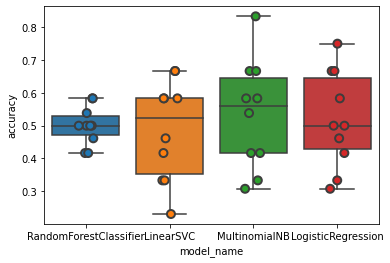

In [193]:
#plots
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.savefig('/content/drive/My Drive/Annotated tweets/2016.png')
plt.show()

In [216]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.604686
LogisticRegression        0.596039
MultinomialNB             0.611256
RandomForestClassifier    0.558937
Name: accuracy, dtype: float64

Model Evaluation

Continue with our best model (X), we are going to look at the confusion matrix, and show the discrepancies between predicted and actual labels.

In [ ]:
pip install preprocessing

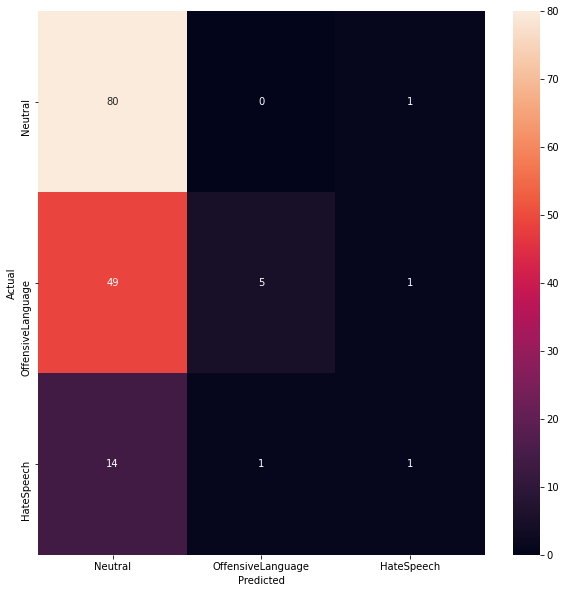

In [217]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing

#models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
#X_train, X_test, y_train, y_test = train_test_split(df['text'], df['intent.id'], random_state = 0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df['intent_id'].values, yticklabels=category_id_df['intent_id'].values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('/content/drive/My Drive/Annotated tweets/confusion_matrix_2015')
plt.show()

In [218]:
from IPython.display import display

for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 10:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['intent_id', 'text']])
      print('')

'OffensiveLanguage' predicted as 'Neutral' : 49 examples.


,intent_id,text
221,OffensiveLanguage,...Companies to come to the U.S.A and to get c...
219,OffensiveLanguage,RT @VP: .@POTUSâ€™ strong stand got Mexico to ...
113,OffensiveLanguage,Once again Israel faces a barrage of deadly ro...
76,OffensiveLanguage,The Democrats are allowing a ridiculous asylum...
457,OffensiveLanguage,â€œPoll shows Dems losing interest in Impeachm...
10,OffensiveLanguage,I often said during rallies with little variat...
220,OffensiveLanguage,Sad when you think about it but Mexico right n...
386,OffensiveLanguage,The President of Ukraine said that he was NOT ...
78,OffensiveLanguage,After many years (decades) Mexico is apprehend...
90,OffensiveLanguage,In New York State Democrats blocked a Bill exp...



'HateSpeech' predicted as 'Neutral' : 14 examples.


,intent_id,text
311,HateSpeech,We are winning big time against China. Compani...
12,HateSpeech,...The Steel Barrier or Wall should have been ...
60,HateSpeech,We are apprehending record numbers of illegal ...
15,HateSpeech,Starting the long overdue pullout from Syria w...
59,HateSpeech,Wall Street Journal: â€œMore migrant families ...
26,HateSpeech,Greatest Witch Hunt in the History of our Coun...
254,HateSpeech,So interesting to see â€œProgressiveâ€ Democr...
20,HateSpeech,Mexico is doing NOTHING to stop the Caravan wh...
272,HateSpeech,RT @KTHopkins: The @realDonaldTrump has made #...
186,HateSpeech,People have been saying for years that we shou...


In [209]:
model.fit(features, labels)

N = 2
for intent_id, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  trigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 3][:N]
  print("# '{}':".format(intent_id))
  print("  . Top unigrams:\n      . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))
  print("  . Top trigrams:\n      . {}".format('\n       . '.join(trigrams)))

# 'HateSpeech':
  . Top unigrams:
      . country
       . ISIS
  . Top bigrams:
       . THE WALL
       . MS 13
  . Top trigrams:
      . North Korean problem
       . help North Korea
# 'Neutral':
  . Top unigrams:
      . https
       . China
  . Top bigrams:
       . President Xi
       . North Korea
  . Top trigrams:
      . President Xi China
       . President Xi Jinping
# 'OffensiveLanguage':
  . Top unigrams:
      . China
       . North
  . Top bigrams:
       . North Korea
       . NYC terrorist
  . Top trigrams:
      . pay big border
       . big border tax


In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['intent_id'].unique(),zero_division=1))

                   precision    recall  f1-score   support

OffensiveLanguage       0.60      0.32      0.41        19
       HateSpeech       0.83      0.45      0.59        11
          Neutral       0.21      0.80      0.33         5

         accuracy                           0.43        35
        macro avg       0.55      0.52      0.45        35
     weighted avg       0.62      0.43      0.46        35

